In [8]:
import pandas as pd

# load dataset
df = pd.read_csv('PhiUSIIL_Phishing_URL_Dataset.csv')  

# group by label and calculate average URLLength
average_lengths = df.groupby('label')['URLLength'].mean()

# print average URL length for each label
for label, avg_length in average_lengths.items():
    print(f"Label: {label}, Average URLLength: {avg_length:.2f}")


Label: 0, Average URLLength: 45.72
Label: 1, Average URLLength: 26.23


Accuracy: 0.9985792743696855
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     20189
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



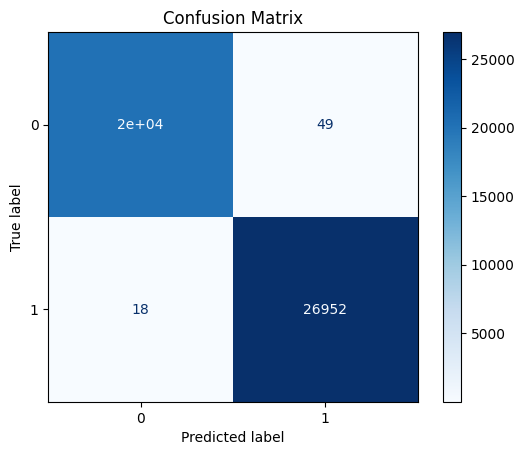

Model saved to url_classifier_model.joblib


In [28]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# training pipeline
def create_training_pipeline():
    numeric_features = [
        "DomainLength", "NoOfImage", "NoOfCSS", "NoOfJS", "NoOfExternalRef",
        "NoOfSubDomain", "NoOfURLRedirect", "NoOfSelfRedirect", "NoOfPopup", "NoOfiFrame", "NoOfSelfRef",
        "IsHTTPS", "HasTitle", "HasDescription", "HasFavicon", "IsResponsive", "HasCopyrightInfo", 
        "HasSocialNet", "HasSubmitButton", "HasHiddenFields"
    ]
    categorical_features = [
        "TLD"
    ]
    
    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ])
    
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(class_weight="balanced", random_state=42))
    ])
    
    return pipeline

# train and save model
def train_model_and_save(df, target_column='label', model_path='url_classifier_model.joblib'):
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    pipeline = create_training_pipeline()
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()
    
    joblib.dump(pipeline, model_path)
    print(f"Model saved to {model_path}")

# load dataset and train
df = pd.read_csv('PhiUSIIL_Phishing_URL_Dataset.csv')
train_model_and_save(df)


In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

# URL feature extractor
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse, urljoin
import re

class URLFeatureExtractor:
    def __init__(self):
        self.features = {}
        
    
    def extract(self, url):
        """Extract features from a given URL"""
        self.features = {}
        self.http_accessible = True  
        
        # extract URL-only features
        self.extract_basic_features(url)
        self.extract_no_of_subdomain(url)
        
        try:
            headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}
            response = requests.get(url, timeout=10, headers=headers)
            
            if response.status_code == 200:
                soup = BeautifulSoup(response.text, 'html.parser')
                self.extract_html_features(soup)
                self.extract_has_favicon(soup)
                self.extract_robot(url)
                self.extract_is_responsive(soup)
                self.extract_no_of_url_redirect(soup)
                self.extract_no_of_self_redirect(soup, url)
                self.extract_popup_and_iframe(soup)
                self.extract_has_copyright_info(soup)
                self.extract_has_social_net(soup)
                self.extract_has_submit_button(soup)
                self.extract_has_hidden_fields(soup)
                self.extract_bank_pay(soup)
                self.extract_no_of_self_ref(soup, url)
            else:
                raise Exception("Non-200 status")
        
        except Exception as e:
            print(f"Unable to fetch content from the URL: {e}")
            print("URL is likely inactive or blocking requests. Only URL-based features will be used.")
            self.set_default_http_features()
            self.http_accessible = False  
    
        return self.features

    
    def extract_basic_features(self, url):
        """Extract basic URL features (your existing ones)"""
        try:
            parsed_url = urlparse(url)
            
            # Domain Length
            domain = parsed_url.netloc
            self.features['DomainLength'] = len(domain)
            
            # TLD
            tld = domain.split('.')[-1] if '.' in domain else ''
            self.features['TLD'] = tld
            
            # IsHTTPS
            self.features['IsHTTPS'] = 1 if parsed_url.scheme == 'https' else 0
            
        except Exception as e:
            print(f"Error extracting basic features: {e}")
    
    def extract_html_features(self, soup):
        # HasTitle
        self.features['HasTitle'] = 1 if soup.find('title') else 0
        
        # HasDescription
        meta_desc = soup.find('meta', attrs={'name': 'description'})
        self.features['HasDescription'] = 1 if meta_desc else 0
        
        # Count features
        self.features['NoOfImage'] = len(soup.find_all('img'))
        self.features['NoOfCSS'] = len(soup.find_all('link', rel='stylesheet'))
        self.features['NoOfJS'] = len(soup.find_all('script'))
        self.features['NoOfExternalRef'] = len(soup.find_all(['link', 'script', 'img'], src=re.compile('^https?://')))
    
    # [All the other methods from previous URLFeatureExtractor implementation]
    # I'm omitting them here for brevity but they should all be included
    # Add these methods inside the URLFeatureExtractor class:

    def extract_no_of_subdomain(self, url):
        """Extract number of subdomains"""
        try:
            parsed_url = urlparse(url)
            hostname = parsed_url.hostname
            parts = hostname.split('.')
            
            # remove TLD to count subdomains
            if len(parts) <= 2:
                self.features['NoOfSubDomain'] = 0
            else:
                # consider the main domain (last two parts) and count rest as subdomains
                self.features['NoOfSubDomain'] = len(parts) - 2
        except Exception as e:
            self.features['NoOfSubDomain'] = -1  # Invalid URL
    
    def extract_has_favicon(self, soup):
        """Check for favicon presence"""
        has_favicon = (soup.find('link', rel=re.compile('icon')) is not None or
                      soup.find('link', rel=re.compile('shortcut')) is not None or
                      soup.find('link', href=re.compile('favicon')) is not None)
        self.features['HasFavicon'] = 1 if has_favicon else 0
    
    def extract_robot(self, url):
        """Check for robots.txt"""
        try:
            parsed_url = urlparse(url)
            robots_url = f"{parsed_url.scheme}://{parsed_url.netloc}/robots.txt"
            response = requests.get(robots_url, timeout=5)
            self.features['Robots'] = 1 if response.status_code == 200 else 0
        except Exception as e:
            self.features['Robots'] = 0
    
    def extract_is_responsive(self, soup):
        """Check if website is responsive"""
        viewport = soup.find('meta', attrs={'name': 'viewport'}) is not None
        responsive_classes = bool(soup.find(class_=re.compile('responsive|container-fluid|col-')))
        
        # Check for media queries in style tags
        has_media_queries = False
        style_tags = soup.find_all('style')
        for style in style_tags:
            if '@media' in style.text:
                has_media_queries = True
                break
        
        self.features['IsResponsive'] = 1 if (viewport or responsive_classes or has_media_queries) else 0
    
    def extract_no_of_url_redirect(self, soup):
        """Extract number of URL redirects"""
        redirect_count = 0
        
        # Check meta refresh
        meta_refresh = soup.find_all('meta', attrs={'http-equiv': 'refresh'})
        redirect_count += len(meta_refresh)
        
        # Check JavaScript redirects
        script_tags = soup.find_all('script')
        redirect_patterns = [
            'window.location',
            'window.location.replace',
            'window.location.href',
            'http.open'
        ]
        
        for script in script_tags:
            if script.string:
                for pattern in redirect_patterns:
                    redirect_count += len(re.findall(pattern, script.string))
        
        self.features['NoOfURLRedirect'] = redirect_count
    
    def extract_no_of_self_redirect(self, soup, url):
        """Extract number of self redirects"""
        parsed_url = urlparse(url)
        current_origin = f"{parsed_url.scheme}://{parsed_url.netloc}"
        self_redirect_count = 0
        
        # check meta refresh for self-redirect
        meta_refresh = soup.find_all('meta', attrs={'http-equiv': 'refresh'})
        for meta in meta_refresh:
            content = meta.get('content', '')
            if current_origin in content:
                self_redirect_count += 1
        
        # check JavaScript self-redirects
        script_tags = soup.find_all('script')
        for script in script_tags:
            if script.string:
                self_redirect_count += len(re.findall(current_origin, script.string))
        
        self.features['NoOfSelfRedirect'] = self_redirect_count
    
    def extract_popup_and_iframe(self, soup):
        """Extract popup and iframe count"""
        popup_count = 0
        
        script_tags = soup.find_all('script')
        for script in script_tags:
            if script.string:
                popup_count += len(re.findall(r'window\.open', script.string))
        
        iframe_count = len(soup.find_all('iframe'))
        
        self.features['NoOfPopup'] = popup_count
        self.features['NoOfiFrame'] = iframe_count
    
    def extract_has_copyright_info(self, soup):
        """Check for copyright information"""
        has_copyright = (soup.text.lower().count('copyright') > 0 or
                        '©' in soup.text or
                        soup.find('footer') is not None)
        self.features['HasCopyrightInfo'] = 1 if has_copyright else 0
    
    def extract_has_social_net(self, soup):
        """Check for social network links"""
        social_networks = ['facebook', 'twitter', 'instagram', 'linkedin', 'youtube']
        has_social_net = False
        
        links = soup.find_all('a', href=True)
        for link in links:
            href = link['href'].lower()
            if any(network in href for network in social_networks):
                has_social_net = True
                break
        
        self.features['HasSocialNet'] = 1 if has_social_net else 0
    
    def extract_has_submit_button(self, soup):
        """Check for submit button"""
        has_submit_button = (soup.find('input', type='submit') is not None or
                           soup.find('button', type='submit') is not None or
                           soup.find('input', value=re.compile('submit')) is not None)
        self.features['HasSubmitButton'] = 1 if has_submit_button else 0
    
    def extract_has_hidden_fields(self, soup):
        """Check for hidden fields"""
        has_hidden_fields = soup.find('input', type='hidden') is not None
        self.features['HasHiddenFields'] = 1 if has_hidden_fields else 0
    
    def extract_bank_pay(self, soup):
        """Check for bank/pay keywords"""
        html_text = soup.text.lower()
        has_bank_pay = 'bank' in html_text or 'pay' in html_text
        self.features['Bank'] = 1 if has_bank_pay else 0
        self.features['Pay'] = 1 if has_bank_pay else 0
    
    def extract_no_of_self_ref(self, soup, url):
        """Extract number of self references"""
        parsed_url = urlparse(url)
        current_domain = parsed_url.hostname
        self_ref_count = 0
        
        links = soup.find_all('a', href=True)
        for link in links:
            try:
                href = link['href']
                link_url = urljoin(url, href)
                link_parsed = urlparse(link_url)
                if link_parsed.hostname == current_domain:
                    self_ref_count += 1
            except:
                # Invalid URL
                pass
        
        self.features['NoOfSelfRef'] = self_ref_count

    def set_default_http_features(self):
        """Set default values for features that require HTTP access"""
        self.features['HasFavicon'] = 0
        self.features['Robots'] = 0
        self.features['IsResponsive'] = 0
        self.features['NoOfURLRedirect'] = 0
        self.features['NoOfSelfRedirect'] = 0
        self.features['NoOfPopup'] = 0
        self.features['NoOfiFrame'] = 0
        self.features['HasCopyrightInfo'] = 0
        self.features['HasSocialNet'] = 0
        self.features['HasSubmitButton'] = 0
        self.features['HasHiddenFields'] = 0
        self.features['Bank'] = 0
        self.features['Pay'] = 0
        self.features['NoOfSelfRef'] = 0
    
    def get_all_features(self):
        """Return all features as a dictionary"""
        return self.features

In [35]:
import joblib
import pandas as pd


def test_random_url(model_path, url):
    model = joblib.load(model_path)
    extractor = URLFeatureExtractor()
    features = extractor.extract(url)
    feature_df = pd.DataFrame([features])

    # Fill in any missing columns with default values
    for feature in ['NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfExternalRef', 'HasTitle', 'HasDescription']:
        if feature not in feature_df.columns:
            feature_df[feature] = 0

    prediction = model.predict(feature_df)
    probability = model.predict_proba(feature_df)

    if not extractor.http_accessible:
        print("\nPrediction is based only on URL-based features since the page could not be loaded.")
        print("Prediction may be less accurate.")

    return {
        'url': url,
        'prediction': prediction[0],
        'probability': probability[0],
        'features': features
    }

# test url
url = 'https://www.reddit.com/r/Gunpla/comments/1kejluh/fm_aerial_the_hype_may_be_over_but_this_is_still/'
result = test_random_url('url_classifier_model.joblib', url)
print("Prediction:", result['prediction'])
print("Probability:", result['probability'])
print("Features:", result['features'])


Prediction: 1
Probability: [0.01 0.99]
Features: {'DomainLength': 14, 'TLD': 'com', 'IsHTTPS': 1, 'NoOfSubDomain': 1, 'HasTitle': 1, 'HasDescription': 0, 'NoOfImage': 14, 'NoOfCSS': 7, 'NoOfJS': 47, 'NoOfExternalRef': 39, 'HasFavicon': 1, 'Robots': 1, 'IsResponsive': 1, 'NoOfURLRedirect': 1, 'NoOfSelfRedirect': 3, 'NoOfPopup': 0, 'NoOfiFrame': 0, 'HasCopyrightInfo': 1, 'HasSocialNet': 0, 'HasSubmitButton': 0, 'HasHiddenFields': 0, 'Bank': 0, 'Pay': 0, 'NoOfSelfRef': 12}
